N= 2, τ=0.910, Erg / <EB> =3.783418
N= 4, τ=0.710, Erg / <EB> =2.560638
N= 6, τ=0.610, Erg / <EB> =2.206824
N= 8, τ=0.510, Erg / <EB> =2.252942
N=10, τ=0.510, Erg / <EB> =1.869411


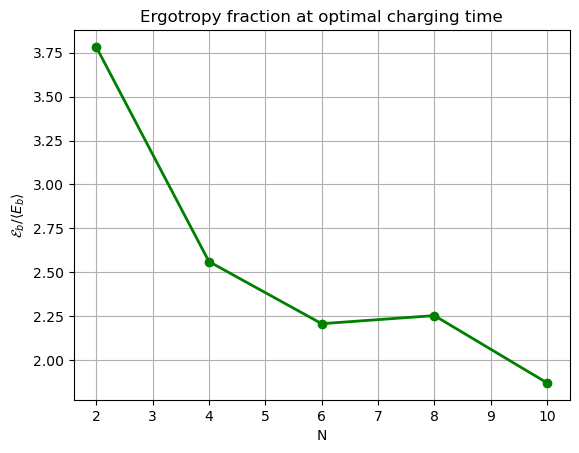

In [3]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

############
# parameters
############

N_arr = np.arange(2, 12, 2)
nmax = 20
ω = 1.0
ω0 = 1.0
g = 1.0
tlist = np.arange(0.01, 2*np.pi, 0.1)

# ------------------
# Tavis–Cummings Hamiltonian
# ------------------
def tavis_cummings(N, nmax, ω, ω0, g):

    a  = qt.destroy(nmax)
    Ic = qt.qeye(nmax)

    sp, sm, sz = qt.sigmap(), qt.sigmam(), qt.sigmaz()

    def embed(op, i):
        ops = [qt.qeye(2)]*N
        ops[i] = op
        return qt.tensor(ops)

    Sp = sum(embed(sp, i) for i in range(N))
    Sm = Sp.dag()
    Sz = 0.5 * sum(embed(sz, i) for i in range(N))

    IB = qt.tensor([qt.qeye(2)]*N)
    HB = ω0 * Sz

    H = (
        ω * qt.tensor(a.dag()*a, IB)
        + qt.tensor(Ic, HB)
        + g * (qt.tensor(a, Sp) + qt.tensor(a.dag(), Sm))
    )

    return H, HB

# ------------------
# Initial state
# ------------------
def initial_state(N, nmax, state):

    if state == "coherent":
        psiA = qt.coherent(nmax, np.sqrt(N))
    elif state == "fock":
        psiA = qt.basis(nmax, N)

    psiB = qt.tensor([qt.basis(2, 1) for _ in range(N)])
    return qt.tensor(psiA, psiB)

#########################################
# optimal charging time τ (maximum power)
#########################################

τ_list = []

for N in N_arr:
    H, HB = tavis_cummings(N, nmax, ω, ω0, g)
    HB_full = qt.tensor(qt.qeye(nmax), HB)
    psi0 = initial_state(N, nmax, "coherent")

    res = qt.sesolve(H, psi0, tlist, e_ops=HB_full)
    EB = np.array(res.expect[0])
    power = EB / tlist

    τ_list.append(tlist[np.argmax(power)])

###########################################
# Calculation of ergotropy and fluctuations
###########################################

E_ratio, F_ratio = [], []

for i, N in enumerate(N_arr):

    τ = τ_list[i]
    
    H, HB = tavis_cummings(N, nmax, ω, ω0, g)
    
    psi0 = initial_state(N, nmax, "coherent")

    res = qt.sesolve(H, psi0, [0, τ], options=opts)
    
    rho_b = res.states[-1].proj().ptrace(list(range(1, N+1)))

    E_B = qt.expect(HB, rho_b)
    
    r_vals, r_vecs = rho_b.eigenstates()
    
    r_vecs = np.sort(rho_b.eigenenergies())[::-1]
    
    # Passive Hamiltonian constructed in the passive state's eigenbasis
    
    e_vals, e_vecs = HB.eigenstates()
    
    H_passive = sum(e_vals[i] * r_vecs[i] * r_vecs[i].conj().T for i in range(len(e_vals)))

    # Ergotropy operator defined w.r.t. passive Hamiltonian
    
    E_op = HB - H_passive
    
    E_B = qt.expect(HB, rho_b)
    
    E_erg = qt.expect(E_op, rho_b)
    
    ΔE = np.sqrt(qt.expect(E_op**2, rho_b) - E_erg**2)

    E_ratio.append(E_erg / E_B)
    
    F_ratio.append(ΔE / E_erg)

for idx, N in enumerate(N_arr):
    print(f"N={N:2d}, τ={τ_list[idx]:.3f}, Erg / <EB> ={E_ratio[idx]:.6f}")


##########################################################
# Plot ergotropy fraction as function of g for different N 
##########################################################

plt.plot(N_arr, E_ratio, 'o-', color='g', linewidth=2)
plt.xlabel("N")
plt.ylabel(r"$\mathcal{E}_b / \langle E_b \rangle$")
plt.title("Ergotropy fraction at optimal charging time")
plt.grid(True)
plt.show()

N= 2, τ=0.910, Relative Fluctuation =0.698400
N= 4, τ=0.710, Relative Fluctuation =0.481916
N= 6, τ=0.610, Relative Fluctuation =0.391335
N= 8, τ=0.510, Relative Fluctuation =0.329063
N=10, τ=0.510, Relative Fluctuation =0.305642


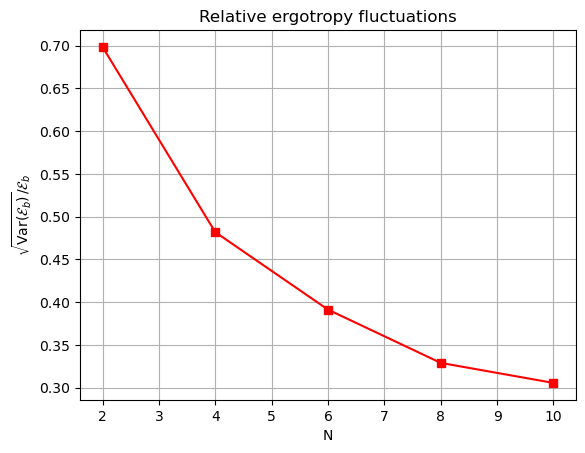

In [4]:
######################################################
# Plot fluctuations as a function of g for different N 
######################################################

for idx, N in enumerate(N_arr):
    print(f"N={N:2d}, τ={τ_list[idx]:.3f}, Relative Fluctuation ={F_ratio[idx]:.6f}")


plt.plot(N_arr, F_ratio, 's-', color='r')
plt.xlabel("N")
plt.ylabel(r"$\sqrt{\mathrm{Var}(\mathcal{E}_b)}/\mathcal{E}_b$")
plt.title("Relative ergotropy fluctuations")
plt.grid(True)
plt.show()